# Function 3: 3D Drug Discovery

*Analogy: **Minimize** side effects. The portal returns raw $y_{\\mathrm{raw}}$ (side effects, higher = worse). We **transform to maximization** by using $y = -y_{\\mathrm{raw}}$ so that our BO framework (EI, PI, UCB) maximizes $y$, which is equivalent to minimizing side effects.*

### Characteristics

* **3D input**: $(x_1, x_2, x_3)$ — e.g. drug formulation or dose parameters in $[0,1]^3$.

* **Objective**: Minimize side effects → we use **y = -raw value** internally so that **maximizing y** = minimizing side effects. Initial data: 15 points, shape (15, 3).

* **Strategy**: Same Bayesian optimisation workflow — GP surrogate, EI/PI/UCB acquisition — in 3D; visualisation uses 3D scatter.


## 1. Setup and load data (read-only from initial_data)


In [1]:
# External
import sys
import copy
import numpy as np
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use("seaborn-v0_8")

# Project + internal
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))
from src.utils.load_challenge_data import load_function_data, load_problem_data_csv, assert_not_under_initial_data
from src.utils.sampling_utils import sample_candidates

np.random.seed(42)


In [2]:
local_dir = repo_root / "data" / "problems" / "function_3"
csv_path = local_dir / "observations.csv"
PLOT_EXPORT_DIR = repo_root / "data" / "results"
print("Set data directory to", local_dir)


Set data directory to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_3


In [3]:
# Run-time flags — toggle without re-running the whole notebook
IF_SHOW_PLOT      = True   # call plt.show() after each figure
IF_EXPORT_PLOT    = False  # save figures to PLOT_EXPORT_DIR
IF_EXPORT_QUERIES = True   # write next_x to data/submissions/
IF_APPEND_DATA    = False  # append new observation to observations.csv
print("Control flags set")


Control flags set


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from skopt.acquisition import gaussian_ei, gaussian_pi, gaussian_lcb


In [5]:
# Size to eval. the acquisition function
n_cand = 2000
CANDIDATE_SAMPLING_METHOD = "sobol"

In [6]:
if csv_path.exists():
    X, y = load_problem_data_csv(csv_path)
else:
    X, y = load_function_data(function_id=3)
    y = -np.asarray(y, dtype=np.float64).ravel()  # minimize raw → maximize y
best_idx = np.argmax(y)
best_y, best_x_so_far = y[best_idx], X[best_idx]
print(f"Loaded: X{X.shape}, y{y.shape}. Best: y={best_y:.4g} at x=({best_x_so_far[0]:.4f}, {best_x_so_far[1]:.4f}, {best_x_so_far[2]:.4f}), n={len(y)}.")

Loaded: X(18, 3), y(18,). Best: y=-0.03484 at x=(0.4926, 0.6116, 0.3402), n=18.


### Progress
Left: y per query. Right: best y so far (cumulative max).

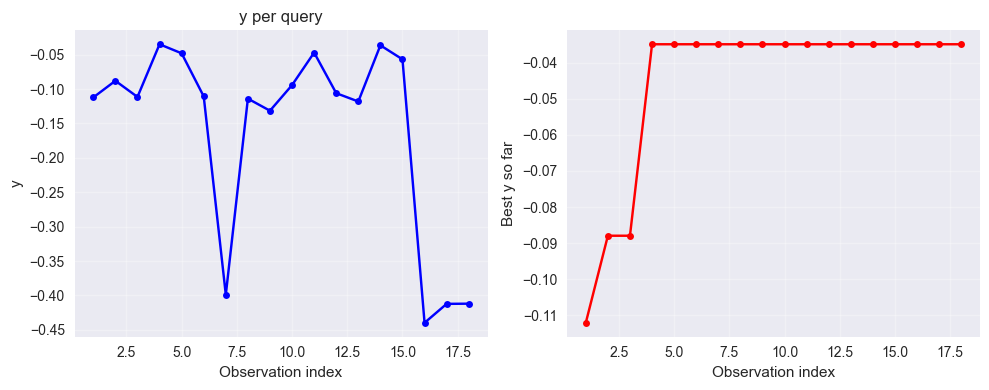

In [7]:
n_obs = len(y)
obs_idx = np.arange(1, n_obs + 1, dtype=float)
best_so_far = np.maximum.accumulate(y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(obs_idx, y, 'o-', color='blue', markersize=5)
ax1.set_xlabel('Observation index')
ax1.set_ylabel('y')
ax1.set_title('y per query')
ax1.grid(True, alpha=0.3)
ax2.plot(obs_idx, best_so_far, 'o-', color='red', markersize=5)
ax2.set_xlabel('Observation index')
ax2.set_ylabel('Best y so far')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. Visualize the points


/Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/src/utils/sampling_utils.py:63: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  x = sampler.random(n=n_sobol)[:n]


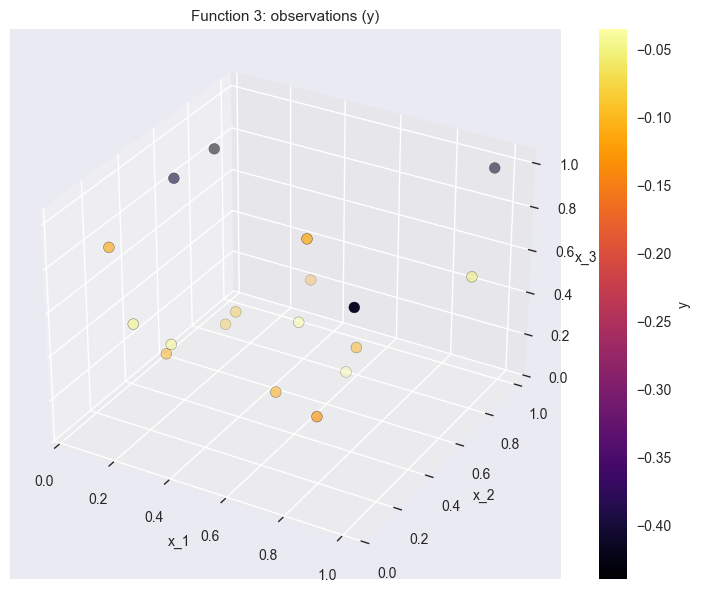

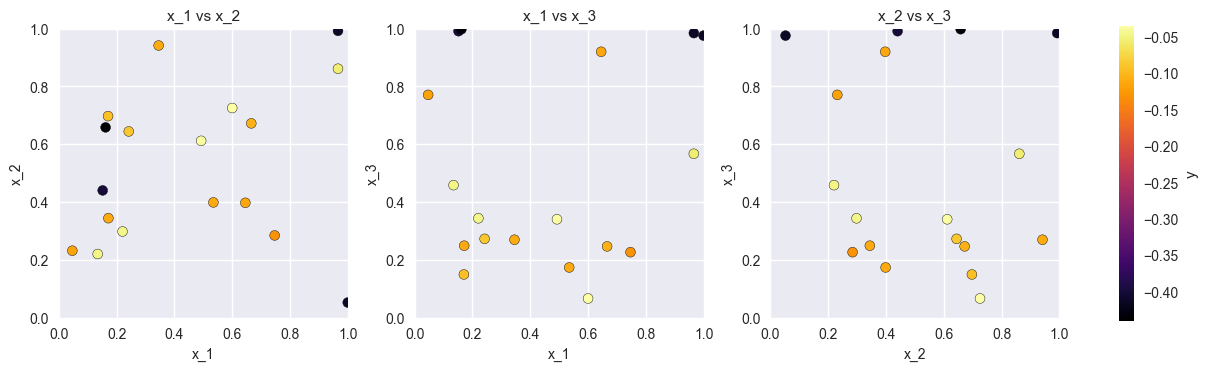

In [8]:
# 3D Drug Discovery: visualise observations in (x_1, x_2, x_3)
# Requires from Section 1: n_cand, CANDIDATE_SAMPLING_METHOD, X, y
# Candidate set for GP/acquisition (3D): uniform-coverage (sobol/lhs) in [0,1]^3
candidate_pts = sample_candidates(n_cand, 3, method=CANDIDATE_SAMPLING_METHOD, seed=42)
# Distance from each candidate to nearest observation (for baseline "high distance" suggestion)
diff = candidate_pts[:, None, :] - X[None, :, :]  # (n_cand, n_obs, 3)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1)  # (n_cand,)

fig = plt.figure(figsize=(8, 6))
ax3d = fig.add_subplot(111, projection="3d")
sc = ax3d.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=60, cmap="inferno", edgecolors="k")
plt.colorbar(sc, ax=ax3d).set_label("y", fontsize=10)
ax3d.set_xlabel("x_1", fontsize=10); ax3d.set_ylabel("x_2", fontsize=10); ax3d.set_zlabel("x_3", fontsize=10); ax3d.set_title("Function 3: observations (y)", fontsize=11)
fig.tight_layout()

# 2D pairwise plots: x_1 vs x_2, x_1 vs x_3, x_2 vs x_3 (same-size subplots, colour = y)
fig2, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)
pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (1, 2, "x_2", "x_3")]
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k")
    ax.set_xlabel(li, fontsize=10); ax.set_ylabel(lj, fontsize=10); ax.set_title(f"{li} vs {lj}", fontsize=11)
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=10)

if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_3d = out_dir / "function_3_observations_3d_scatter.png"
    fig.savefig(out_path_3d, dpi=150, format="png")
    print("Plot saved to", out_path_3d)
    out_path_2d = out_dir / "function_3_observations_2d_pairs.png"
    fig2.savefig(out_path_2d, dpi=150, format="png")
    print("Plot saved to", out_path_2d)
if IF_SHOW_PLOT:
    plt.show()


## 3. Suggest next point to submit, using Bayesian Optimization Methodology


### 3.1 Surrogate: GP kernels

 * **Gaussian Process (GP)** — we compare three kernel choices below; each gives a different prior over functions and uncertainty:

    - **RBF kernel** — Smooth, infinitely differentiable prior; single length-scale. *Differs:* no explicit noise term (fixed small `alpha` for stability).

    - **Matérn kernel (ν=1.5)** — Less smooth than RBF; allows rougher, more "wiggly" surfaces. *Differs:* better when the true function has sharper changes or only finitely many derivatives.

    - **RBF + WhiteKernel** — Same smoothness as RBF but adds a separate noise term. *Differs:* explicitly models observation noise; uncertainty splits into noise vs interpolation.


In [9]:
# Coefficients of the Probabilistic Surrogate Models (used by GP kernels and acquisition functions below)

# --- GP / kernel (surrogate) ---
CONSTANT_KERNEL_SCALE = 1.0       # signal variance (output scale); typical: 0.1–10
LENGTH_SCALE = 0.1                # correlation length; typical for [0,1]²: 0.1–1
GP_ALPHA = 1e-6                   # diagonal jitter for numerical stability; typical: 1e-8–1e-4
MATERN_NU = 1.5                   # Matérn smoothness (1.5 = once differentiable); typical: 0.5, 1.5, 2.5
WHITE_NOISE_LEVEL = 1e-3         # F3 drug discovery: moderate noise term so GP doesn't overtrust observations

# --- Acquisition functions ---   F1: EI (Expected Improvement) as primary acquisition; F3: prioritise exploration (find safe region).
XI_EI_PI = 0.18                  # typical [0.01–0.2]; 0.18 = high end (within logical limit)
KAPPA_UCB = 6.0                  # UCB: μ + κσ; typical 2–6, 6 = strong exploration


In [10]:
# Three kernels on (X, y); predict on candidate_pts (3D).
kernel_RBF = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE) + WhiteKernel(noise_level=WHITE_NOISE_LEVEL)
kernel_Matern = ConstantKernel(CONSTANT_KERNEL_SCALE) * Matern(length_scale=LENGTH_SCALE, nu=MATERN_NU)
kernel_RBF_noise = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE) + WhiteKernel(noise_level=WHITE_NOISE_LEVEL)
gp_RBF = GaussianProcessRegressor(kernel=kernel_RBF, alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)
gp_Matern = GaussianProcessRegressor(kernel=kernel_Matern, alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)
gp_RBF_noise = GaussianProcessRegressor(kernel=kernel_RBF_noise, alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)
gp_RBF.fit(X, y); gp_Matern.fit(X, y); gp_RBF_noise.fit(X, y)
mu_cand_RBF, sigma_cand_RBF = gp_RBF.predict(candidate_pts, return_std=True)
mu_cand_Matern, sigma_cand_Matern = gp_Matern.predict(candidate_pts, return_std=True)
mu_cand_RBF_noise, sigma_cand_RBF_noise = gp_RBF_noise.predict(candidate_pts, return_std=True)
gp_neg_RBF = copy.deepcopy(gp_RBF); gp_neg_Matern = copy.deepcopy(gp_Matern); gp_neg_RBF_noise = copy.deepcopy(gp_RBF_noise)
gp_neg_RBF.fit(X, -y); gp_neg_Matern.fit(X, -y); gp_neg_RBF_noise.fit(X, -y)
print("GP RBF:", gp_RBF.kernel_)


GP RBF: 1.05**2 * RBF(length_scale=0.28) + WhiteKernel(noise_level=0.00413)


In [11]:
lml = {n: g.log_marginal_likelihood_value_ for g, _, n in [(gp_RBF, gp_neg_RBF, "RBF"), (gp_Matern, gp_neg_Matern, "Matern"), (gp_RBF_noise, gp_neg_RBF_noise, "RBF+White")]}
best_name = max(lml, key=lml.get)
for n, v in lml.items(): print(f"  {n}: {v:.4f}" + ("  ← best" if n == best_name else ""))
best_gp = next(g for g, _, n in [(gp_RBF, gp_neg_RBF, "RBF"), (gp_Matern, gp_neg_Matern, "Matern"), (gp_RBF_noise, gp_neg_RBF_noise, "RBF+White")] if n == best_name)
best_gp_neg = next(gn for _, gn, n in [(gp_RBF, gp_neg_RBF, "RBF"), (gp_Matern, gp_neg_Matern, "Matern"), (gp_RBF_noise, gp_neg_RBF_noise, "RBF+White")] if n == best_name)
print("Best:", best_name)


  RBF: -20.3663  ← best
  Matern: -20.9285
  RBF+White: -20.3663
Best: RBF


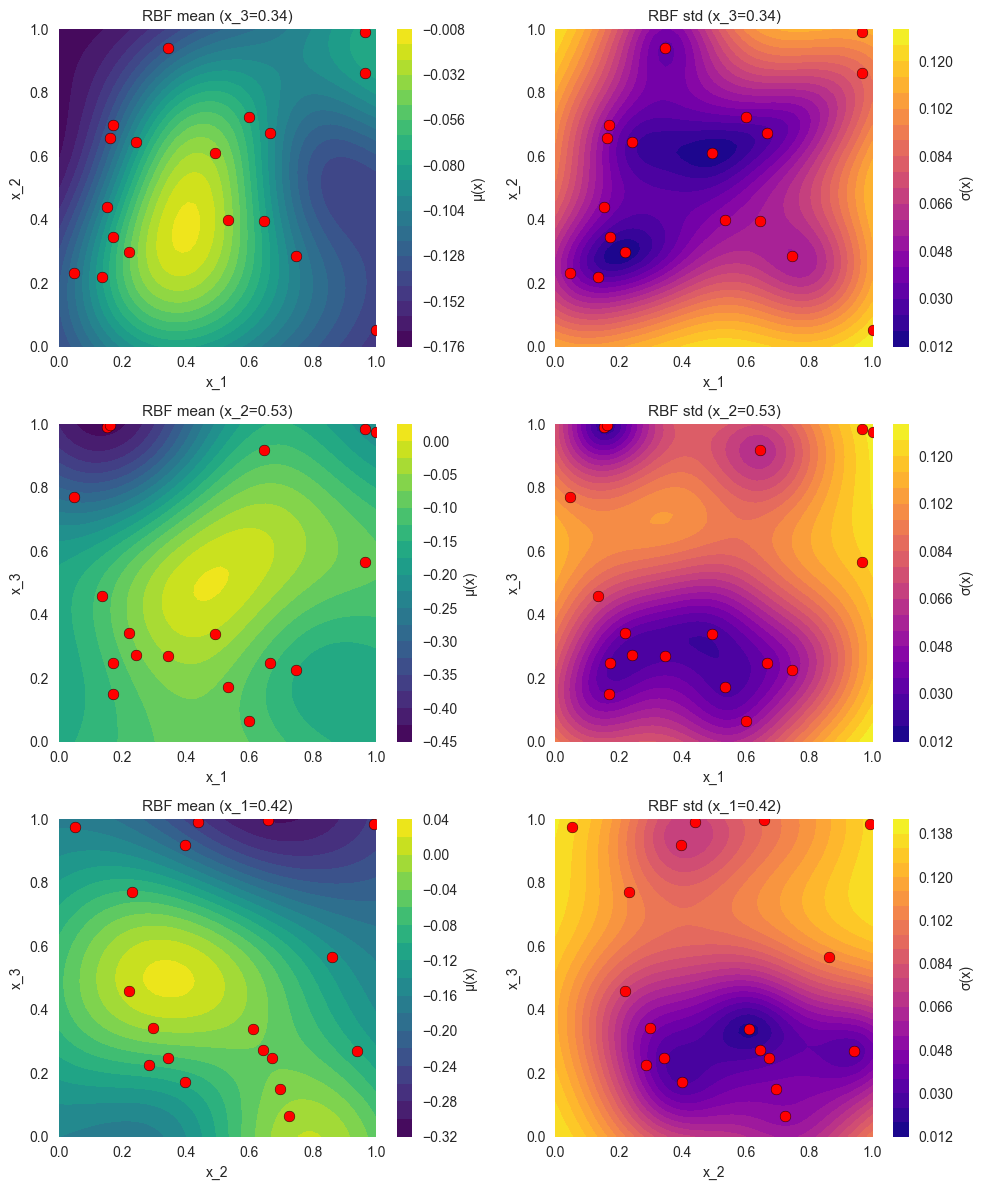

In [12]:
# 2D slices of GP posterior (best kernel by LML)
n_slice = 50
ug = np.linspace(0, 1, n_slice)
Ug, Vg = np.meshgrid(ug, ug)
med = [np.median(X[:, k]) for k in range(3)]
slices_info = [
    (np.column_stack([Ug.ravel(), Vg.ravel(), np.full(Ug.size, med[2])]), Ug, Vg, 0, 1, "x_1", "x_2", f"x_3={med[2]:.2f}"),
    (np.column_stack([Ug.ravel(), np.full(Ug.size, med[1]), Vg.ravel()]), Ug, Vg, 0, 2, "x_1", "x_3", f"x_2={med[1]:.2f}"),
    (np.column_stack([np.full(Ug.size, med[0]), Ug.ravel(), Vg.ravel()]), Ug, Vg, 1, 2, "x_2", "x_3", f"x_1={med[0]:.2f}"),
]
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
for row, (slice_pts, Ag, Bg, ia, ib, la, lb, slice_label) in enumerate(slices_info):
    mu_slice, sigma_slice = best_gp.predict(slice_pts, return_std=True)
    mu_slice = mu_slice.reshape(Ug.shape); sigma_slice = sigma_slice.reshape(Ug.shape)
    ax_mu, ax_sig = axes[row, 0], axes[row, 1]
    cf1 = ax_mu.contourf(Ag, Bg, mu_slice, levels=20, cmap="viridis")
    plt.colorbar(cf1, ax=ax_mu).set_label("μ(x)", fontsize=10)
    ax_mu.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    ax_mu.set_xlabel(la, fontsize=10); ax_mu.set_ylabel(lb, fontsize=10); ax_mu.set_title(f"{best_name} mean ({slice_label})", fontsize=11)
    ax_mu.set_aspect("equal")
    cf2 = ax_sig.contourf(Ag, Bg, sigma_slice, levels=20, cmap="plasma")
    plt.colorbar(cf2, ax=ax_sig).set_label("σ(x)", fontsize=10)
    ax_sig.scatter(X[:, ia], X[:, ib], c="red", s=60, edgecolors="k")
    ax_sig.set_xlabel(la, fontsize=10); ax_sig.set_ylabel(lb, fontsize=10); ax_sig.set_title(f"{best_name} std ({slice_label})", fontsize=11)
    ax_sig.set_aspect("equal")
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / "function_3_gp_slices.png", dpi=150, bbox_inches="tight")
if IF_SHOW_PLOT: plt.show()


### 3.2 Acquisition functions

* Expected Improvement (EI)

* Upper Confidence Bound (UCB)

* Probability of Improvement (PI)


In [13]:
y_best = best_y
EI_RBF = gaussian_ei(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
x_best_EI_RBF = candidate_pts[np.argmax(EI_RBF)]
PI_RBF = gaussian_pi(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
x_best_PI_RBF = candidate_pts[np.argmax(PI_RBF)]
LCB_RBF = gaussian_lcb(candidate_pts, best_gp_neg, kappa=KAPPA_UCB)
x_best_UCB_RBF = candidate_pts[np.argmin(LCB_RBF)]
print("EI:", x_best_EI_RBF, "UCB:", x_best_UCB_RBF, "Best y:", y_best)


EI: [0.49578395 0.20841578 0.58997474] UCB: [0.512514   0.00265358 0.674039  ] Best y: -0.034835313350078584


In [14]:
# Baseline: point with highest distance to nearest observation (used as fallback in Section 5 if EI suggestion is too close to data).
idx_high_dist = np.argmax(min_dist)
next_x_high_dist = np.clip(np.asarray(candidate_pts[idx_high_dist]).ravel(), 0.0, 0.999999)


### 3.3 Acquisition function surfaces
In 3D we evaluate EI/UCB on `candidate_pts` (no 2D contour); Section 4 shows the suggested next points (EI, PI, UCB) in 3D and 2D pairs.

### Pairwise distances between suggestions (small = agree)
Small values mean two strategies agree; large values mean they point to different regions.


In [15]:
# Compare suggested points (acquisition + high-distance baseline)
names = ['EI', 'UCB', 'PI', 'High dist']
pts = [np.asarray(x).ravel() for x in [x_best_EI_RBF, x_best_UCB_RBF, x_best_PI_RBF, next_x_high_dist]]
n_pts = len(pts)
dists = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    for j in range(n_pts):
        dists[i, j] = np.linalg.norm(pts[i] - pts[j])
print("Pairwise L2 distances between acquisition suggestions:")
for i in range(n_pts):
    for j in range(i + 1, n_pts):
        print(f"  {names[i]} vs {names[j]}: {dists[i, j]:.4f}")
max_d = dists.max()
if max_d < 0.2:
    print("\n>>> Suggestions are similar (max pairwise distance < 0.2).")
else:
    print(f"\n>>> Suggestions differ (max pairwise distance = {max_d:.4f}); consider comparing strategies.")


Pairwise L2 distances between acquisition suggestions:
  EI vs UCB: 0.2229
  EI vs PI: 0.1066
  EI vs High dist: 0.7498
  UCB vs PI: 0.3204
  UCB vs High dist: 0.9411
  PI vs High dist: 0.6459

>>> Suggestions differ (max pairwise distance = 0.9411); consider comparing strategies.


## 4. Select next query

Pick the next input to submit. **EI RBF** (Expected Improvement with RBF kernel) is the default. **Strategy:** Start with EI and **max exploration** — in the coefficients cell (Section 3.1), `XI_EI_PI = 0.18` gives strong exploration (higher than the usual 0.01); you can try 0.2 for even more. See how it goes; later you can lower it for more exploitation. Alternative: `next_x_high_dist` (high distance to obs — explore unexplored regions).


In [16]:
# Choose the next query point — swap variable to change strategy:
#   EI from best kernel (LML) — exploit + explore balance (recommended default)
#   x_best_UCB_RBF / x_best_PI_RBF — broader exploration / greedy
#   next_x_high_dist — maximum gap from existing obs (pure explore)

# Use best kernel (auto-selected by LML); fall back to RBF if not available
EI_best = gaussian_ei(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
next_x  = candidate_pts[np.argmax(EI_best)]
next_x  = np.clip(np.asarray(next_x).ravel(), 0.0, 0.999999)

# Proximity check: warn if suggested point is too close to any existing observation (3D)
MIN_DIST_THRESHOLD = 0.05  # minimum acceptable L2 distance from any existing obs
dist_to_obs = np.sqrt(((X - next_x) ** 2).sum(axis=1))
nearest_idx  = np.argmin(dist_to_obs)
nearest_dist = dist_to_obs[nearest_idx]
if nearest_dist < MIN_DIST_THRESHOLD:
    print(f"⚠ WARNING: suggested point is only {nearest_dist:.4f} from obs #{nearest_idx+1} "
          f"at ({X[nearest_idx,0]:.4f}, {X[nearest_idx,1]:.4f}, {X[nearest_idx,2]:.4f}) — consider next_x_high_dist instead.")
    next_x = next_x_high_dist
    print(f"  Auto-switched to high-dist fallback: ({next_x[0]:.4f}, {next_x[1]:.4f}, {next_x[2]:.4f})")
    nearest_dist = np.sqrt(((X - next_x) ** 2).sum(axis=1)).min()
    nearest_idx  = np.argmin(np.sqrt(((X - next_x) ** 2).sum(axis=1)))

print(f"Next query | kernel: {best_name} | strategy: EI | xi={XI_EI_PI}")
print(f"  x = ({next_x[0]:.4f}, {next_x[1]:.4f}, {next_x[2]:.4f})")
print(f"  Nearest existing obs: #{nearest_idx+1} at dist={nearest_dist:.4f}")
print(f"  Current best y = {best_y:.4g} at ({best_x_so_far[0]:.4f}, {best_x_so_far[1]:.4f}, {best_x_so_far[2]:.4f})")


Next query | kernel: RBF | strategy: EI | xi=0.18
  x = (0.4958, 0.2084, 0.5900)
  Nearest existing obs: #11 at dist=0.3801
  Current best y = -0.03484 at (0.4926, 0.6116, 0.3402)


## 5. Illustrate the locations on the proposed query


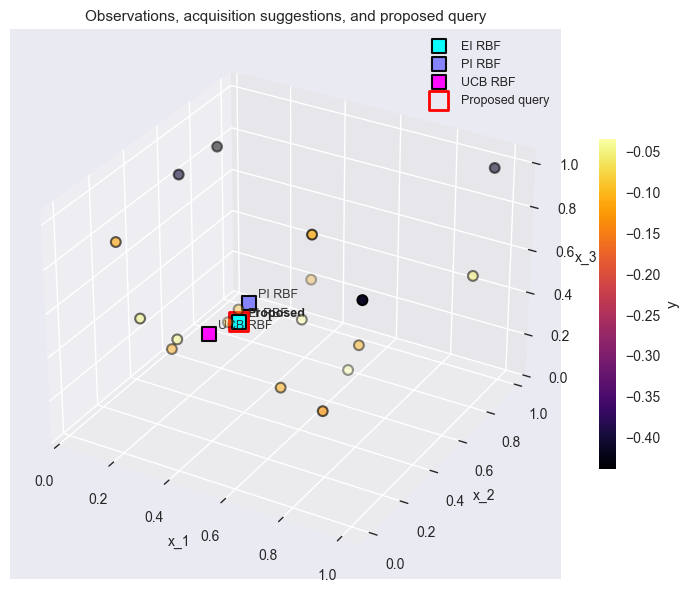

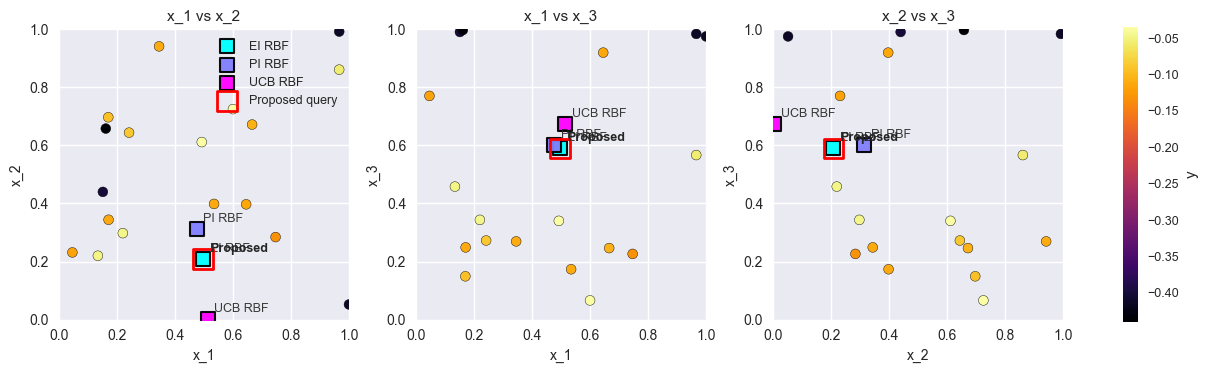

In [17]:
# PLOT EI + PI + UCB (acquisition next points) — 3D scatter and 2D pairwise view
# next_x is set in Section 4 (Select next query); fallback below if that cell was skipped
try:
    _ = next_x
except NameError:
    _ei = gaussian_ei(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
    next_x = np.clip(np.asarray(candidate_pts[np.argmax(_ei)]).ravel(), 0.0, 0.999999)

X_best_combined = np.array([x_best_EI_RBF, x_best_PI_RBF, x_best_UCB_RBF])
labels_combined = ['EI RBF', 'PI RBF', 'UCB RBF']
colors_combined = plt.cm.cool(np.linspace(0, 1, len(X_best_combined)))
next_x_plot = np.asarray(next_x).ravel()

# Figure 1: 3D scatter (observations + EI, PI, UCB + proposed query)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap="inferno", edgecolors="k", linewidths=1.5)
plt.colorbar(sc, ax=ax, label="y", shrink=0.6)
for i, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
    ax.scatter(pt[0], pt[1], pt[2], c=[colors_combined[i]], s=100, marker='s', edgecolors="k", linewidths=1.5, alpha=0.95, label=lbl)
    ax.text(pt[0] + 0.02, pt[1] + 0.02, pt[2] + 0.02, lbl, fontsize=9, alpha=0.9)
ax.scatter(next_x_plot[0], next_x_plot[1], next_x_plot[2], facecolors='none', s=200, marker='s', edgecolors='red', linewidths=2, label='Proposed query', zorder=10)
ax.text(next_x_plot[0] + 0.02, next_x_plot[1] + 0.02, next_x_plot[2] + 0.02, 'Proposed', fontsize=9, fontweight='bold')
ax.set_xlabel("x_1", fontsize=10); ax.set_ylabel("x_2", fontsize=10); ax.set_zlabel("x_3", fontsize=10)
ax.set_title("Observations, acquisition suggestions, and proposed query", fontsize=11)
ax.legend(loc="upper right", fontsize=9)
fig.tight_layout()

# Figure 2: 2D pairwise view (x_1 vs x_2, x_1 vs x_3, x_2 vs x_3) — same layout as observations
fig2, axes = plt.subplots(1, 3, figsize=(12, 5), constrained_layout=True)
pairs = [(0, 1, "x_1", "x_2"), (0, 2, "x_1", "x_3"), (1, 2, "x_2", "x_3")]
for ax, (i, j, li, lj) in zip(axes, pairs):
    sc = ax.scatter(X[:, i], X[:, j], c=y, s=50, cmap="inferno", edgecolors="k", zorder=2)
    for k, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
        ax.scatter(pt[i], pt[j], c=[colors_combined[k]], s=100, marker='s', edgecolors="k", linewidths=1.5, alpha=0.95, label=lbl, zorder=3)
        ax.annotate(lbl, (pt[i], pt[j]), xytext=(5, 5), textcoords="offset points", fontsize=9, alpha=0.9, zorder=4)
    ax.scatter(next_x_plot[i], next_x_plot[j], facecolors='none', s=200, marker='s', edgecolors='red', linewidths=2, label='Proposed query', zorder=5)
    ax.annotate('Proposed', (next_x_plot[i], next_x_plot[j]), xytext=(5, 5), textcoords="offset points", fontsize=9, fontweight='bold', zorder=6)
    ax.set_xlabel(li, fontsize=10); ax.set_ylabel(lj, fontsize=10); ax.set_title(f"{li} vs {lj}", fontsize=11)
    ax.set_aspect("equal")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
axes[0].legend(loc="upper right", fontsize=9)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(y.min(), y.max()), cmap="inferno")
sm.set_array(y)
cbar = fig2.colorbar(sm, ax=axes, shrink=0.6, label="y")
cbar.ax.tick_params(labelsize=9)

if IF_SHOW_PLOT:
    plt.show()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "function_3_all_acquisition_points.png"
    fig.savefig(out_path, dpi=150, format="png")
    print("Plot saved to", out_path)
    out_path_2d = out_dir / "function_3_acquisition_points_2d_pairs.png"
    fig2.savefig(out_path_2d, dpi=150, format="png")
    print("Plot saved to", out_path_2d)


In [18]:
# Save next query: .npy for downstream code, .txt for the portal submission form
if IF_EXPORT_QUERIES:
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_3"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved. Portal string:", portal_str)
else:
    print("IF_EXPORT_QUERIES=False; not saved.")


Saved. Portal string: 0.495784-0.208416-0.589975
